# Import Libraries

In [32]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [33]:
print("TensorFlow Version:",tf.__version__)

TensorFlow Version: 2.16.1


# Load Data

In [2]:
root_dir = "./mp/samples"

In [3]:
image_paths = []
labels = []

for file in tqdm.tqdm(os.listdir(root_dir)):
    filepath = os.path.join(root_dir, file)
    label = filepath.split("/")[-1].split(".")[0]

    image_paths.append(filepath)
    labels.append(label)

100%|██████████| 585/585 [00:00<00:00, 974838.24it/s]


In [4]:
images_df = pd.DataFrame({"image_path": image_paths, "label": labels})
images_df.head()

,image_path,label
0,./mp/samples/259276.png,259276
1,./mp/samples/312075.png,312075
2,./mp/samples/231690.png,231690
3,./mp/samples/618793.png,618793
4,./mp/samples/668260.png,668260


In [5]:
characters = set(char for label in labels for char in label)
print("Characters:\n", characters)

Characters:
 {'7', '5', '0', '3', '1', '8', '9', '2', '6', '4'}


# Preprocess

In [6]:
char_to_num = layers.StringLookup(
    vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [7]:
pd.DataFrame({"char": char_to_num.get_vocabulary(),
              "num": np.arange(1, len(char_to_num.get_vocabulary())+1)})

,char,num
0,7,1
1,5,2
2,0,3
3,3,4
4,1,5
5,8,6
6,9,7
7,2,8
8,6,9
9,4,10


In [8]:
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [9]:
def encode_single_sample(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.image.resize(image, [50, 200])
    image = tf.transpose(image, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return image, label

In [10]:
def process_dataset(X, y):
    images = []
    labels = []
    for img_path, label in zip(X, y):
        img, lbl = encode_single_sample(img_path, label)
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_paths), 
                                                    np.array(labels), 
                                                    test_size=0.10, random_state=42)

In [12]:
X_train_processed, y_train_processed = process_dataset(X_train, y_train)
X_test_processed, y_test_processed = process_dataset(X_test, y_test)

In [13]:
X_train_input = {"Input": X_train_processed, "Label": y_train_processed}
X_test_input = {"Input": X_test_processed, "Label": y_test_processed}

# Visualization

In [14]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"CAPTCHA: {label}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

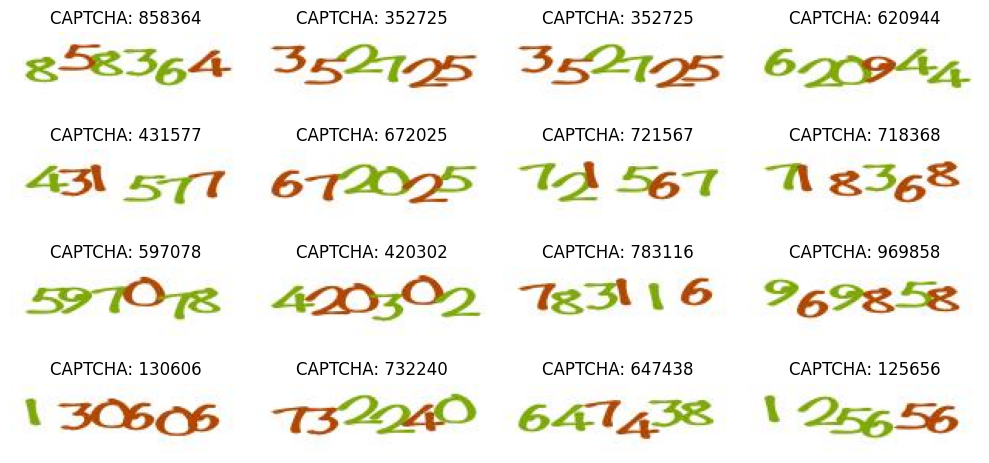

In [15]:
visualize_df(images_df)

# Model

In [16]:
class CTCLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [17]:
input_layer = layers.Input(shape=(150, 45, 3), name="Input", dtype="float32")
label_layer = layers.Input(shape=(None,), name="Label", dtype="float32")

conv2_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_layer)
max2_1 = layers.MaxPooling2D(strides=(2, 2))(conv2_1)

conv2_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(max2_1)
max2_2 = layers.MaxPooling2D(strides=(2, 2))(conv2_2)

reshape_layer = layers.Reshape(target_shape=((150 // 4), (45 // 4) * 64))(max2_2)
dense_1 = layers.Dense(units=32, activation="relu")(reshape_layer)
drop_1 = layers.Dropout((0.2))(dense_1)

bilstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(drop_1)
bilstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(bilstm_1)

output_layer = layers.Dense(len(characters) + 1, activation="softmax", name="Output")(bilstm_2)

output = CTCLayer(name="ctc_loss")(label_layer, output_layer)

model = models.Model(inputs=[input_layer, label_layer], outputs=output, name="OCR")

In [18]:
model.compile(optimizer=optimizers.Adam())

In [19]:
model.summary()

Model: "OCR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 150, 45,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 45,   │        896 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 22,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 22,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 11,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 37, 704)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 37, 32)    │     22,560 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 37, 32)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 37, 256)   │    164,864 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 37, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 37, 11)    │      1,419 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 37, 11)    │          0 │ Label[0][0],      │
│                     │                   │            │ Output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 372,587 (1.42 MB)

 Trainable params: 372,587 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

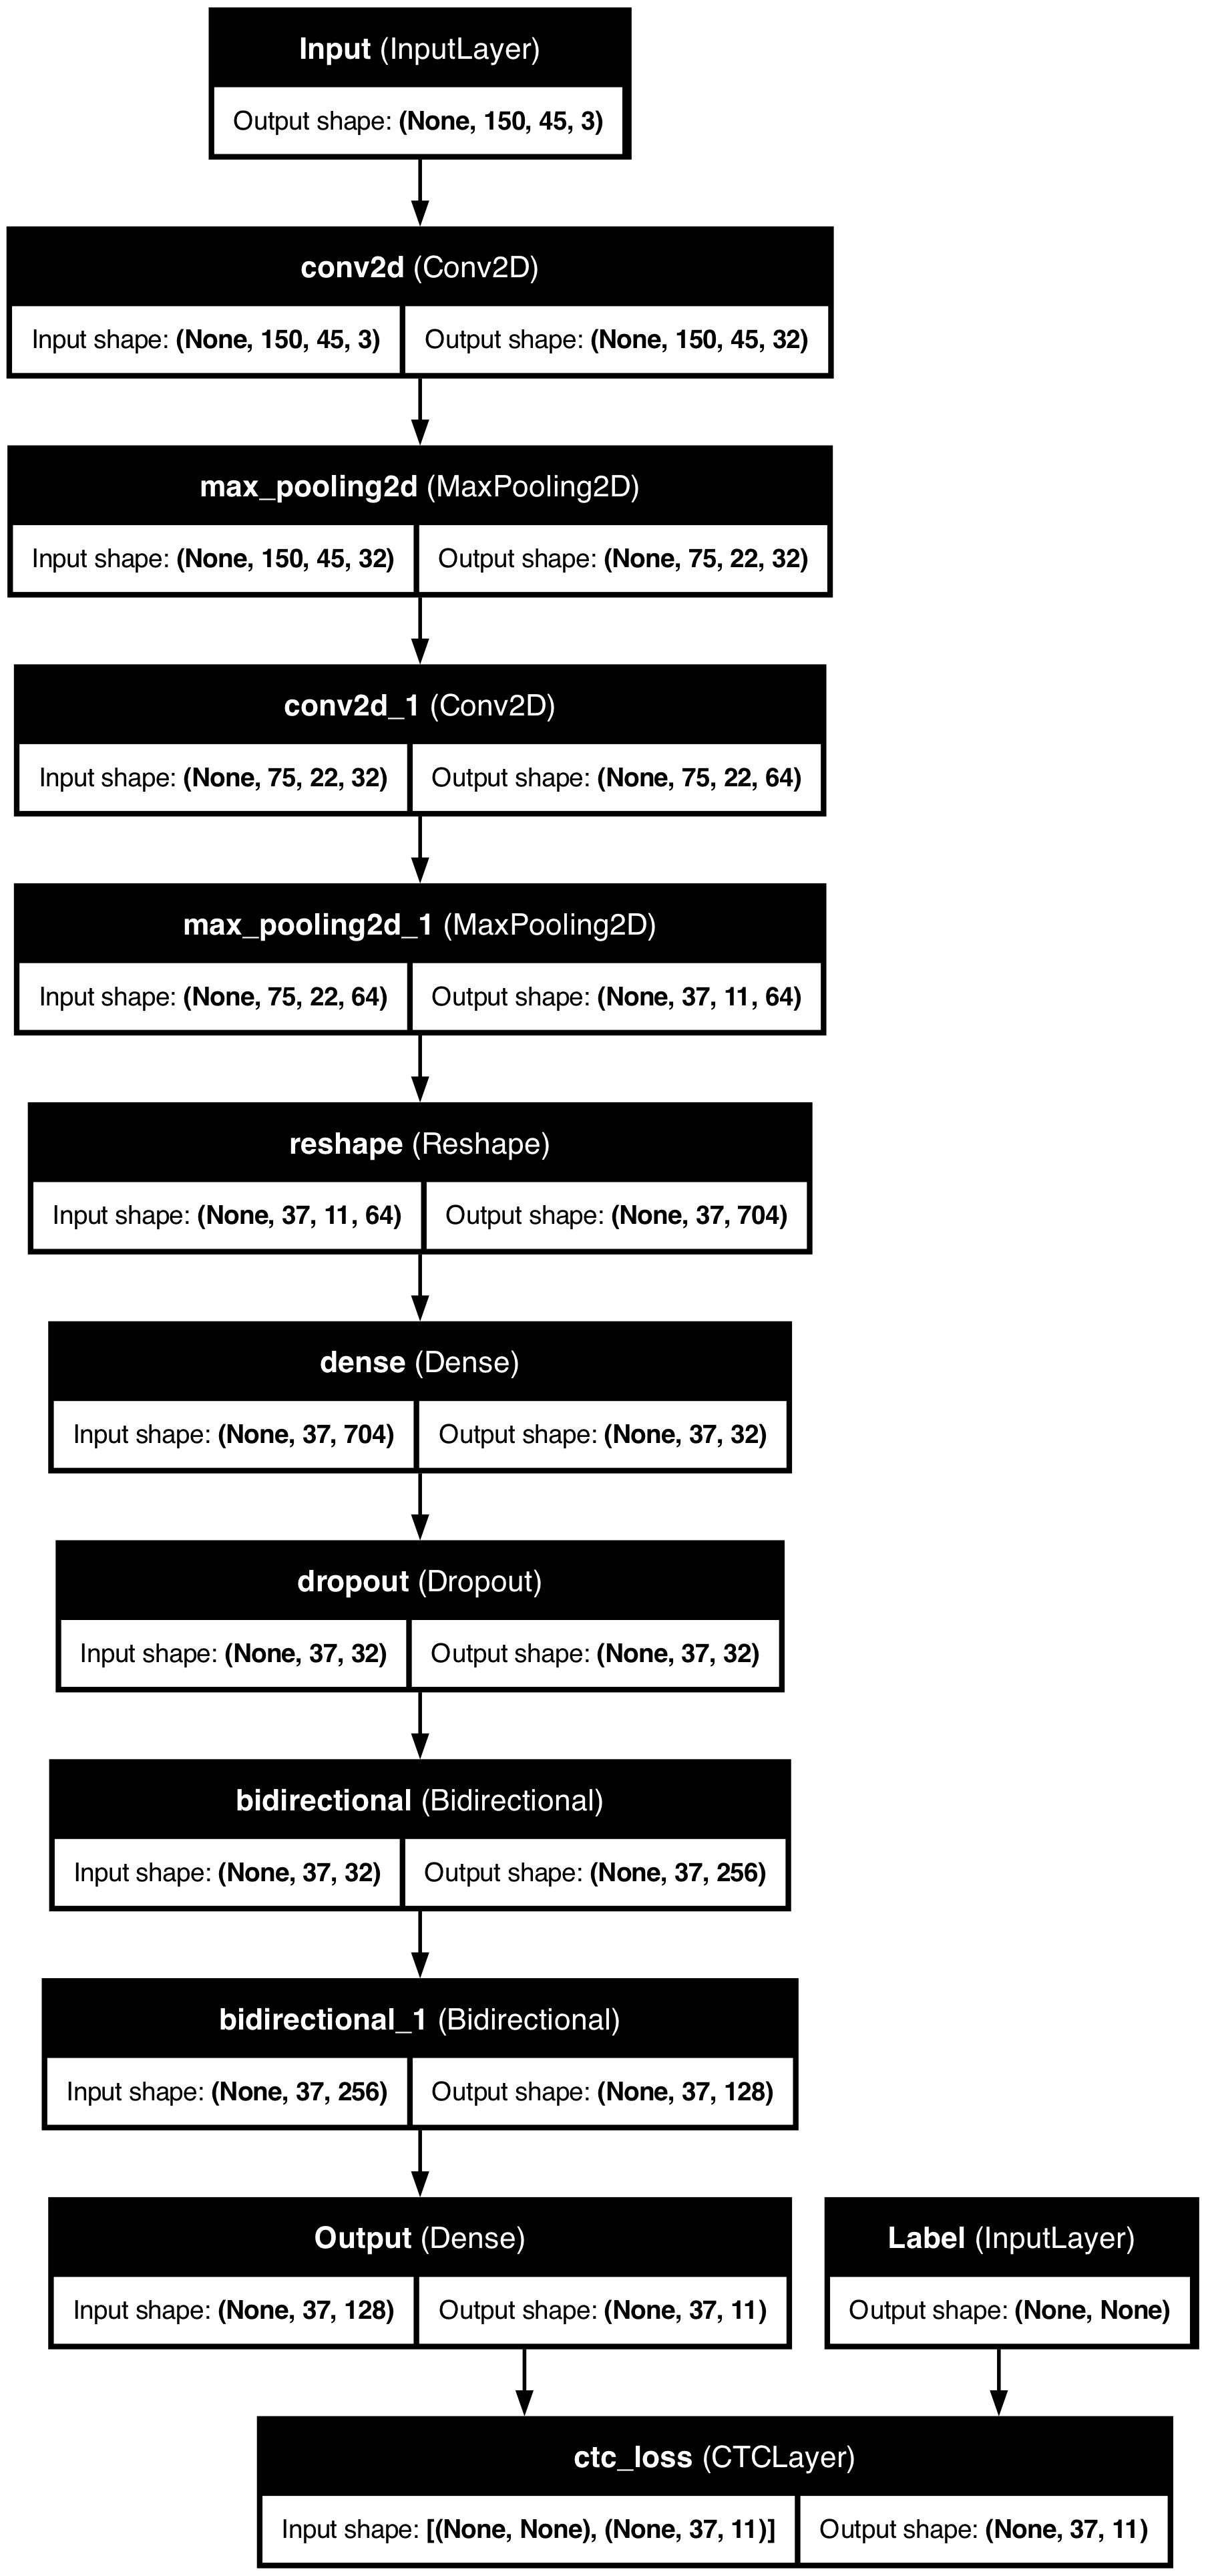

In [20]:
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

# Train

In [21]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [22]:
history = model.fit(
    X_train_input,
    y_train_processed,
    validation_data=(X_test_input, y_test_processed),
    epochs=200,
    batch_size=32,
    # callbacks=[early_stopping]
)
model.save("captcha_mpets_200ep_586_ds5.keras")

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 986.2930 - val_loss: 469.9648
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 507.2738 - val_loss: 461.0139
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 497.4720 - val_loss: 461.0527
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 497.2515 - val_loss: 460.5479
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 496.2678 - val_loss: 461.0599
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 496.4175 - val_loss: 460.4949
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 496.5832 - val_loss: 461.2593
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 495.9627 - val_loss: 459.9048
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 495.9308 - val_loss: 460.5808
Epoch 10/200
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 496.4590

KeyboardInterrupt: 

# Results

In [ ]:
# from keras import models
# model = models.load_model("captcha_mpets.keras", custom_objects={"CTCLayer": CTCLayer})

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["Обучение", "Валидация"])
plt.title("Кривая потерь")
plt.show()

# Test

In [ ]:
preds = model.predict(X_test_input)
input_length = np.ones(preds.shape[0]) * preds.shape[1]
results = ctc_decode(preds, input_length=input_length, greedy=True)[0][0][:, :6]
pred_texts = []
for result in results:
    res = tf.strings.reduce_join(num_to_char(result+1)).numpy().decode("utf-8")
    pred_texts.append(res)


In [ ]:
pred_df = pd.DataFrame({
    "Путь до файла": X_test,
    "Ожидалось": y_test,
    "Результат": pred_texts,
    "Совпадение": [1 if y_test[i] == pred_texts[i] else 0 for i in range(len(y_test))]
})
print(X_test)

In [ ]:
pred_df.head(1000)

In [ ]:
pred_df.to_excel("preds.xlsx")

In [ ]:
def visualize_predictions(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            pred = df.loc[a][["pred"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"Ожидалось: {label}\nРезультат: {pred}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_predictions(pred_df)